# NSRDB Distributed (API Key Required)


In [1]:
from dask.distributed import LocalCluster, Client
from dotenv import load_dotenv
import pvdeg
import os

# Setting Up

We need to get ready to make our parallelized API calls. You need to import your API key and email. This cell will not work for you unless you replace the `api_key` and `email` with your personal NSRDB api keys. [REQUEST A KEY](https://developer.nrel.gov/signup/).

We also need to initalize a dask client. `pvdeg.weather.weather_distributed` will not work without it. It will fail silently and not populate and of the results in the resulting `weather_ds` called `geo_weather` in the example below. It is hard to recognize that this has occured so be careful. Make sure to initialize a dask client first. Visiting the link takes you to a daskboard that shows what dask is doing.

In [2]:
load_dotenv()

### REPLACE WITH YOUR API KEY AND EMAIL ###
api_key = "DEMO_KEY"
email = "user@mail.com"
###########################################

workers = 4

cluster = LocalCluster(
    n_workers=workers,
    processes=True,
)

client = Client(cluster)

print("Daskboard link")
print(client.dashboard_link)

Daskboard link
http://127.0.0.1:8787/status


**Note on .env file:** Create a file named `.env` in your project root directory (`c:\Users\rdaxini\Documents\GitHub\PVDegradationTools_NREL\`) with the following content:
```
api_key=YOUR_NREL_API_KEY
email=YOUR_EMAIL_ADDRESS
```
Replace `YOUR_NREL_API_KEY` and `YOUR_EMAIL_ADDRESS` with your actual NREL developer credentials.

# Requesting Weather

We will create a list of tuple (latitude, longitude) pairs and call the function on all of them at once. failed will represent a list of failed gids, unique location ID's that correspond to points in space on the NSRDB. These are different than on PVGIS where they are arbitrary indexes that do NOT correspond to a spatial location on earth.

We will request "PSM4" data from the Physical Solar Model that represents a typical meteorological year (TMY) from the NSRDB. We will have to supply the api key and email from above here. The only difference between other weather sources lies in the NSRDB/PSM4 data requiring API keys.

In [3]:
coords = [
    (25.783388, -80.189029),
    (24.783388, -80.189029),
]

geo_weather, geo_meta, failed = pvdeg.weather.weather_distributed(
    database="PSM4", coords=coords, api_key=api_key, email=email
)

Connected to a Dask scheduler | Dashboard: http://127.0.0.1:8787/status


# Viewing Results

Same as in the other tutorial, our results are stored in an xarray dataset with a dask backend so you will have to use `.compute()` on the dataset to inspect the individual values of the dask arrays.

Click on the `Data variables` dropdown to expand the dataset viewer.

In [4]:
geo_weather

<xarray.Dataset> Size: 2MB
Dimensions:            (gid: 2, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int64 16B 0 1
Data variables: (12/15)
    Year               (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Month              (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Day                (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Hour               (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Minute             (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    temp_air           (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    ...                 ...
    ghi                (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    albedo             (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    pressure           (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    wind_direction     (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    wind_speed         (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    relative_humidity  (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>

In [5]:
geo_weather.compute()

<xarray.Dataset> Size: 2MB
Dimensions:            (gid: 2, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int64 16B 0 1
Data variables: (12/15)
    Year               (gid, time) float64 140kB 2.019e+03 ... 2.02e+03
    Month              (gid, time) float64 140kB 1.0 1.0 1.0 ... 12.0 12.0 12.0
    Day                (gid, time) float64 140kB 1.0 1.0 1.0 ... 31.0 31.0 31.0
    Hour               (gid, time) float64 140kB 0.0 1.0 2.0 ... 21.0 22.0 23.0
    Minute             (gid, time) float64 140kB 30.0 30.0 30.0 ... 30.0 30.0
    temp_air           (gid, time) float64 140kB 24.1 24.1 24.0 ... 24.7 24.7
    ...                 ...
    ghi                (gid, time) float64 140kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    albedo             (gid, time) float64 140kB 0.08 0.08 0.08 ... 0.0 0.0 0.0
    pressure           (gid, time) float64 140kB 1.019e+03 ... 1.02e+03
    wind_direction     (gid, time) float64 140kB 128.0 126.0 ... 121.0 123.0
    wind_speed         (gid, time) float64 140kB 3.6 3.5 3.4 3.4 ... 9.0 9.0 8.8
    relative_humidity  (gid, time) float64 140kB 87.0 86.47 85.93 ... 84.96 86.0

# Spot Check

We can plot the entire TMY air_temperature to check that our data has loaded correctly.

Explanation of steps

geo_weather is our weather xarray dataset. We can index into the first entry at the 0th index by using isel (index-select). This will grab the data from the first gid. Then we pick the air temperature attribute. This can be replaced with bracket notation so `.temp_air` becomes `["temp_air"].

This selects a single array from the dataset that is labeled as "temp_air". This array will be a dask array so the values will be stored out of memory, we would have to load it using `.compute()` to directly inspect it but when plotting with matplotlib it will load the array for us.

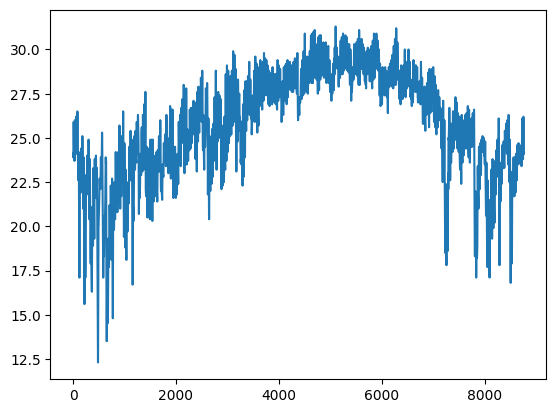

In [6]:
import matplotlib.pyplot as plt

plt.plot(geo_weather.isel(gid=0).temp_air)

# Next Steps

Now we have data ready to use for geospatial calculations. You can see how to do this in [Geospatial Templates.ipynb](../04_geospatial/02_geospatial_templates.ipynb)